In [1]:
%reset -sf

import tensorflow as tf
print(tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_384 # Set the memory limit in MB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

w = tf.constant(
    [
        [1.0, 2.0, 3.0, 4.0], # time-like
        [0.0, 0.0, 0.0, 9.0], # time-like
        [2.0, 3.0, 4.0, 5.0], # space-like
        [0.0, 0.0, 0.0, 0.0], # space-like
    ],
    dtype=tf.float32,
)
px = w[:, 0]
py = w[:, 1]
pz = w[:, 2]
energy = w[:, 3]
# Calculate the constraint
constraint = tf.maximum(0.0, energy**2 - px**2 - py**2 - pz**2)
# Create a mask for valid four-vectors
mask = tf.cast(tf.not_equal(constraint, 0.0), w.dtype)
# If constraint is zero, set the entire four-vector to zero
w * tf.expand_dims(mask, axis=-1)

2024-07-23 15:39:13.733180: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 15:39:13.752598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
1 Physical GPUs, 1 Logical GPU


2024-07-23 15:39:14.578421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16384 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-07-23 15:39:14.586326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 16.00GiB (17179869184 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-07-23 15:39:14.586514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 14.40GiB (15461881856 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [0., 0., 0., 9.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [2]:
import sys
HOME_PATH = "./work/QE-mls/"
sys.path.insert(0, HOME_PATH+"qe")
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

import os
import glob

from matplotlib import pyplot as plt
import matplotlib as mpl
import shap

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/opt/miniconda3/envs/work_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 32
Number of used processors: 19

['/data/truth/signal/CGLMP.npz', '/data/truth/signal/Higgs.npz', '/data/truth/signal/LeadLepton.npz', '/data/truth/signal/LeptonM.npz', '/data/truth/signal/LeptonP.npz', '/data/truth/signal/LmNu.npz', '/data/truth/signal/LpNu.npz', '/data/truth/signal/MET.npz', '/data/truth/signal/WmBoson.npz', '/data/truth/signal/WpBoson.npz', '/data/truth/signal/diLepton.npz', '/data/truth/signal/subLeadLepton.npz', '/data/truth/signal/xi_xyz.npz']



In [4]:
## Global variables

GEV = 1e3

# cut_pre_pt_lead = data.LeadLep["pt"] > 35 * GEV
# cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
# cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
# cut_pre_pt_miss = data.MET["pt"] > 20 * GEV

cut_pre_pt_lead = data.LeadLep["pt"] > -9999 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > -9999 * GEV
cut_pre_dilep_m = data.diLep["m"] > -9999 * GEV
cut_pre_pt_miss = data.MET["pt"] > -9999 * GEV

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 4_096
EPOCHS = 1_024
LEARNING_RATE = 5e-5

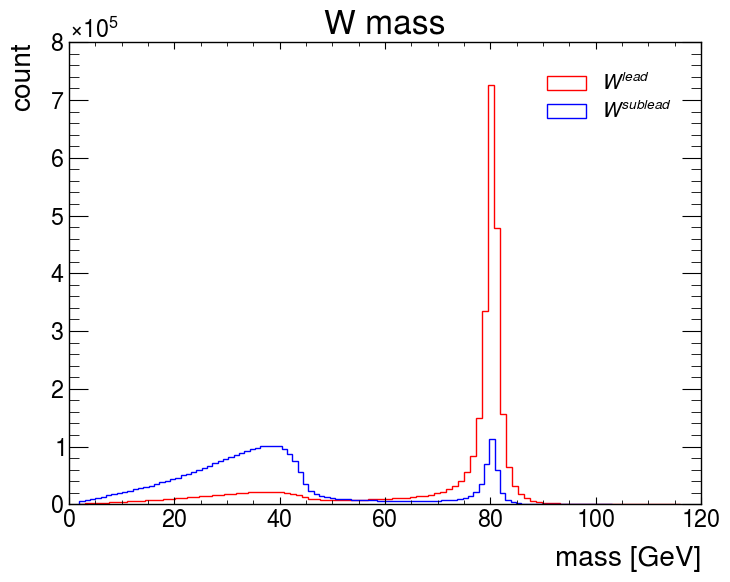

int_kin shape: (2928862, 4)
                 px            py            pz             E
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06
mean  -2.686588e-02 -1.476071e-02  1.933113e-01  1.404083e+02
std    2.429328e+01  2.430197e+01  2.074607e+02  1.624061e+02
min   -6.911612e+02 -8.249657e+02 -3.927153e+03  5.416974e+00
25%   -1.384852e+01 -1.383030e+01 -6.225817e+01  5.182750e+01
50%   -1.345119e-02 -2.286590e-03  1.198130e-01  8.548199e+01
75%    1.379049e+01  1.381654e+01  6.263841e+01  1.579316e+02
max    4.730691e+02  5.995815e+02  3.658318e+03  3.927979e+03
<class 'numpy.ndarray'>


In [5]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
# print("w_lead shape:", w_lead.shape)
# print(w_lead.head(3))
# print(w_lead.describe())

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=100, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=100, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()
# # Check (sub)lead W
# plt.hist(
#     w_lead["m"][PRE_CUT] / GEV,
#     bins=100,
#     color="r",
#     histtype="step",
#     label=r"$W^{lead}$",
# )
# plt.hist(
#     w_sublead["m"][PRE_CUT] / GEV,
#     bins=100,
#     color="b",
#     histtype="step",
#     label=r"$W^{sublead}$",
# )
# plt.title("Cut W mass")
# plt.xlabel("mass [GeV]")
# plt.ylabel("count")
# plt.legend(loc="best")
# plt.show()
# plt.close()

# Kinematics of interesting variables (target for training)
int_kin = w_sublead[["px", "py", "pz", "E"]][PRE_CUT] / GEV
print("int_kin shape:", int_kin.shape)
print(int_kin.describe())
int_kin = int_kin.to_numpy() # convert to numpy array
print(type(int_kin))

In [6]:
## Observing variables

met = data.MET[["px", "py"]]
lead_lep = data.LeadLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]
sublead_lep = data.SubLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (2928862, 16)
<class 'numpy.ndarray'>


In [7]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.6,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (1757317, 16);
Validing data shape: (585772, 16);
Testing data shape: (585773, 16).
Y (Observed)
Training data shape: (1757317, 4);
Validing data shape: (585772, 4);
Testing data shape: (585773, 4).


In [8]:
# Define a new activation function


def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)


class EPConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        # Ensure that energy-momentum are time-like case
        px = w[:, 0]
        py = w[:, 1]
        pz = w[:, 2]
        energy = w[:, 3]
        # Calculate the constraint
        constraint = tf.maximum(0.0, energy**2 - px**2 - py**2 - pz**2)
        # Create a mask for invalid four-vectors (constraint == 0)
        mask = tf.cast(tf.not_equal(constraint, 0.0), w.dtype)
        # If constraint is zero, set the entire four-vector to zero
        adjusted_w = w * tf.expand_dims(mask, axis=-1)
        return adjusted_w

# Register the custom activation and constraint
tf.keras.utils.get_custom_objects().update({
    'EPConstraint': EPConstraint,
})


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=1024, activation="elu")(x)
    x = tf.keras.layers.Dense(units=1024, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    x = tf.keras.layers.Dense(units=128, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)

    # Last dense layer(s)
    # x = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)
    # x = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear", kernel_constraint=EPConstraint())(x)
    # outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear", kernel_constraint=EPConstraint())(x)
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.losses.MeanSquaredLogarithmicError(),
    )

    return model

In [9]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1024)              17408     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 128)               16512 

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=20,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.01)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    use_multiprocessing=True,
    callbacks=[stop_early],
    # callbacks=[stop_early,lr_scheduler],
)

Epoch 1/1024


2024-07-23 15:39:21.437066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-23 15:39:21.448096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0581798700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 15:39:21.448107: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-07-23 15:39:21.450209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 15:39:21.456313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-07-23 15:39:21.508507: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of

430/430 - 3s - loss: 3.4714 - val_loss: 1.9189 - 3s/epoch - 8ms/step
Epoch 2/1024
430/430 - 2s - loss: 1.7559 - val_loss: 1.6091 - 2s/epoch - 5ms/step
Epoch 3/1024
430/430 - 2s - loss: 1.5317 - val_loss: 1.4082 - 2s/epoch - 5ms/step
Epoch 4/1024
430/430 - 2s - loss: 1.3454 - val_loss: 1.1675 - 2s/epoch - 5ms/step
Epoch 5/1024
430/430 - 2s - loss: 1.0790 - val_loss: 0.9092 - 2s/epoch - 5ms/step
Epoch 6/1024
430/430 - 2s - loss: 0.9246 - val_loss: 0.8665 - 2s/epoch - 5ms/step
Epoch 7/1024
430/430 - 2s - loss: 0.8936 - val_loss: 0.8475 - 2s/epoch - 5ms/step
Epoch 8/1024
430/430 - 2s - loss: 0.8742 - val_loss: 0.8337 - 2s/epoch - 5ms/step
Epoch 9/1024
430/430 - 2s - loss: 0.8591 - val_loss: 0.8236 - 2s/epoch - 4ms/step
Epoch 10/1024
430/430 - 1s - loss: 0.8479 - val_loss: 0.8165 - 1s/epoch - 3ms/step
Epoch 11/1024
430/430 - 2s - loss: 0.8389 - val_loss: 0.8111 - 2s/epoch - 4ms/step
Epoch 12/1024
430/430 - 2s - loss: 0.8323 - val_loss: 0.8065 - 2s/epoch - 4ms/step
Epoch 13/1024
430/430 - 2s

In [11]:
# Make a directory
dir_name = HOME_PATH + "4th_trial//w_sublead_result/"
name = "dnn_w_sublead_full_scaled"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
else:
    os.makedirs(dir_name)

# save model
model.save(dir_name + name + ".h5", save_format="h5", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

  326/18306 [..............................] - ETA: 5s 

/opt/miniconda3/envs/work_env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18306/18306 [==============================] - 6s 307us/step


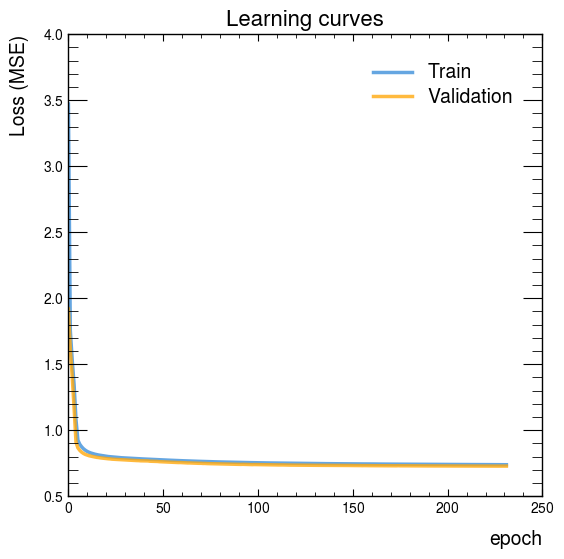

In [12]:
plot.plot_loss_history(history, logx=False, logy=False)

In [13]:
# sig_truth_inv = ROBUST_INT.inverse_transform(sig_truth)
# sig_pred_inv = ROBUST_INT.inverse_transform(sig_pred)
sig_truth_inv = sig_truth
sig_pred_inv = sig_pred

In [14]:
# name the file
name = "dnn_w_sublead_full"

# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz", pred_y=sig_pred_inv, test_y=sig_truth_inv
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: -0.043, std: 24.389, min: -691.161, max: 473.069


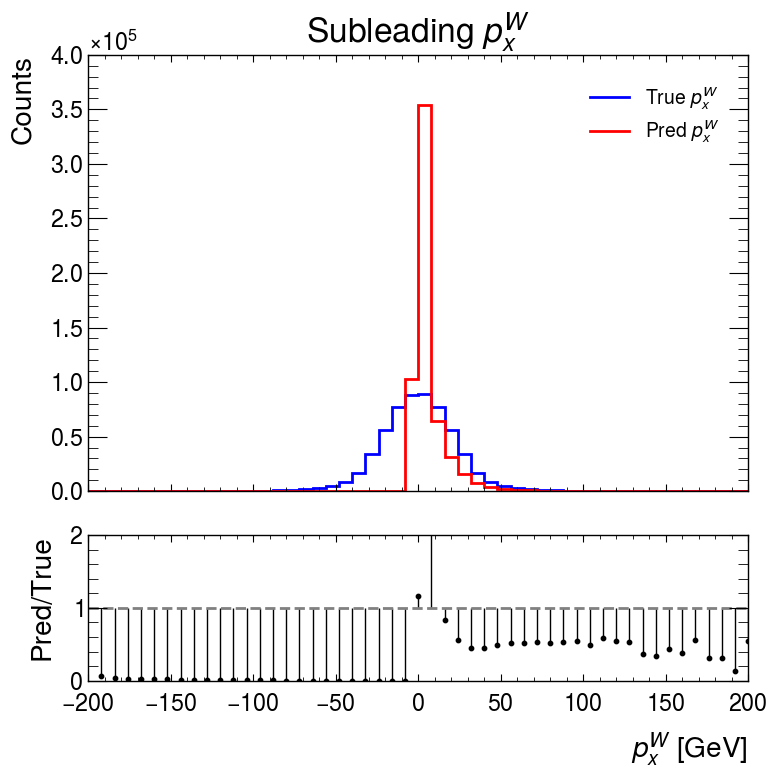

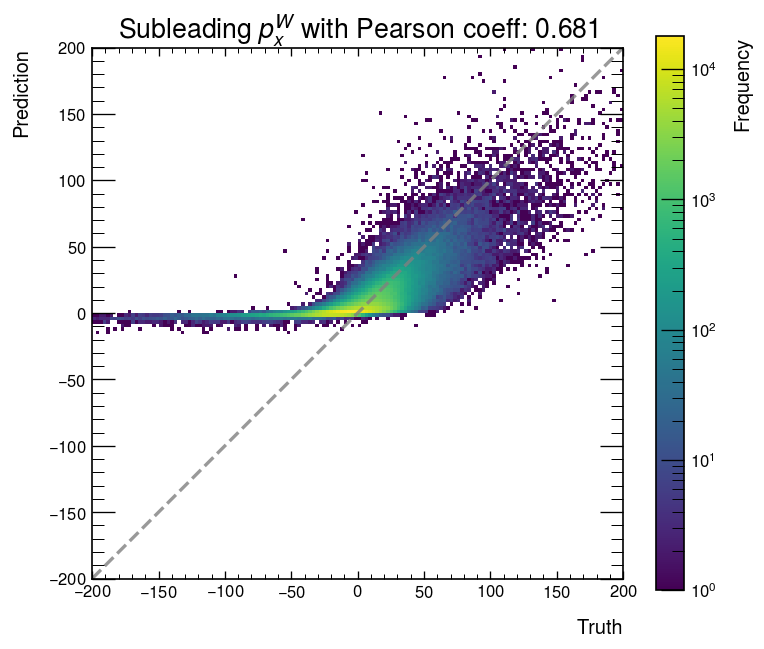

In [15]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}^{W}$",
    title="Subleading $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"Subleading $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.034, std: 24.321, min: -515.411, max: 580.447


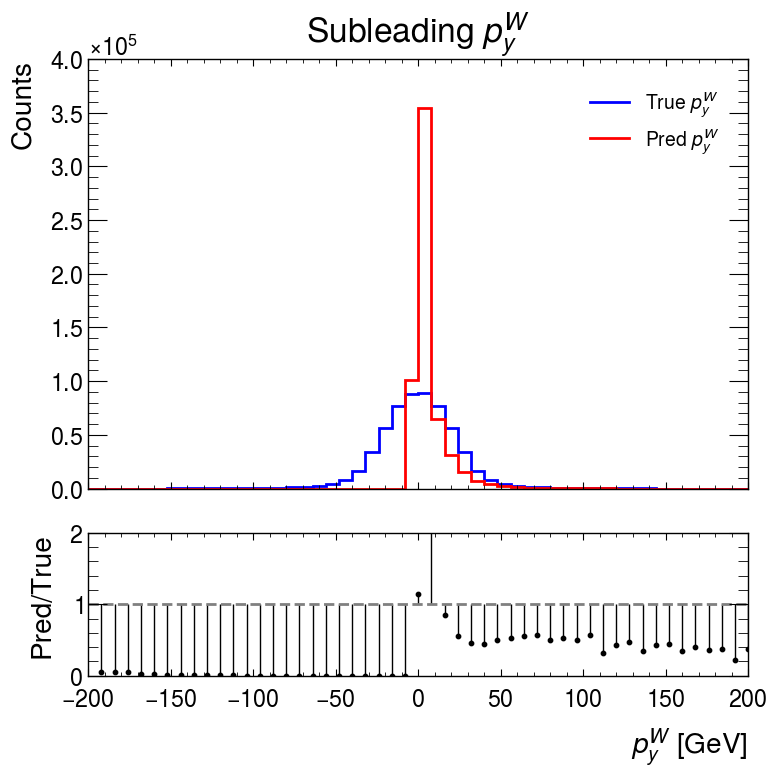

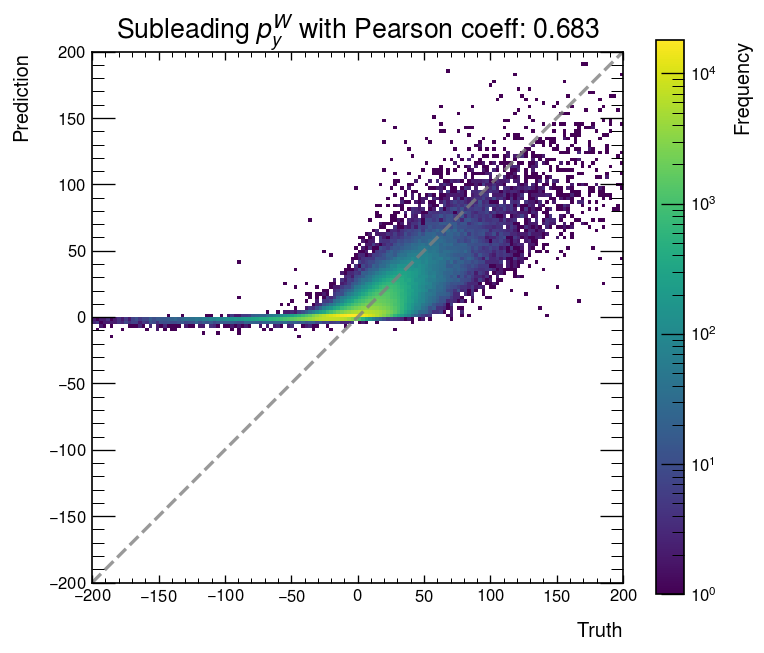

In [16]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}^{W}$",
    title="Subleading $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"Subleading $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.244, std: 207.122, min: -3215.880, max: 2989.094


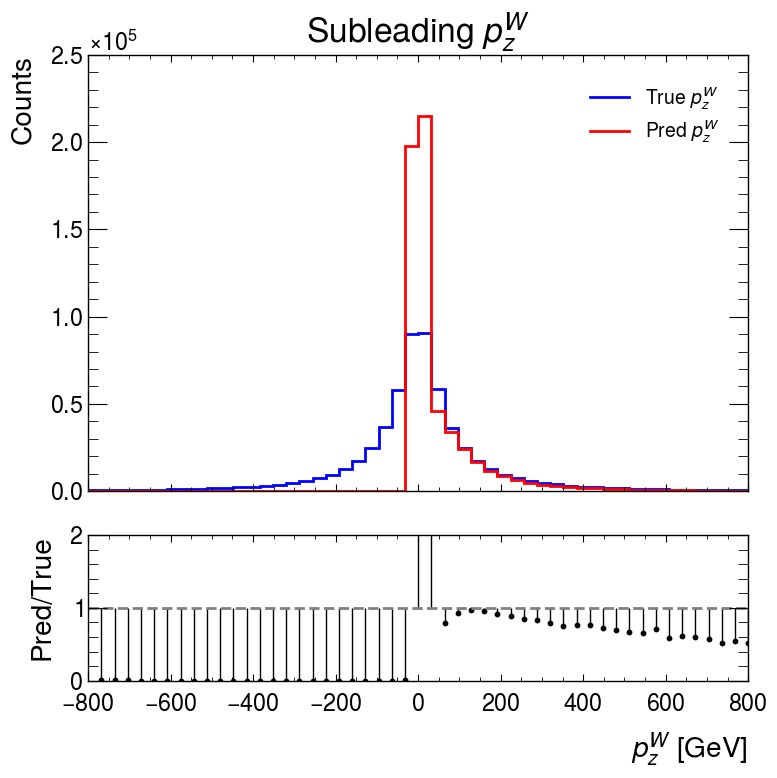

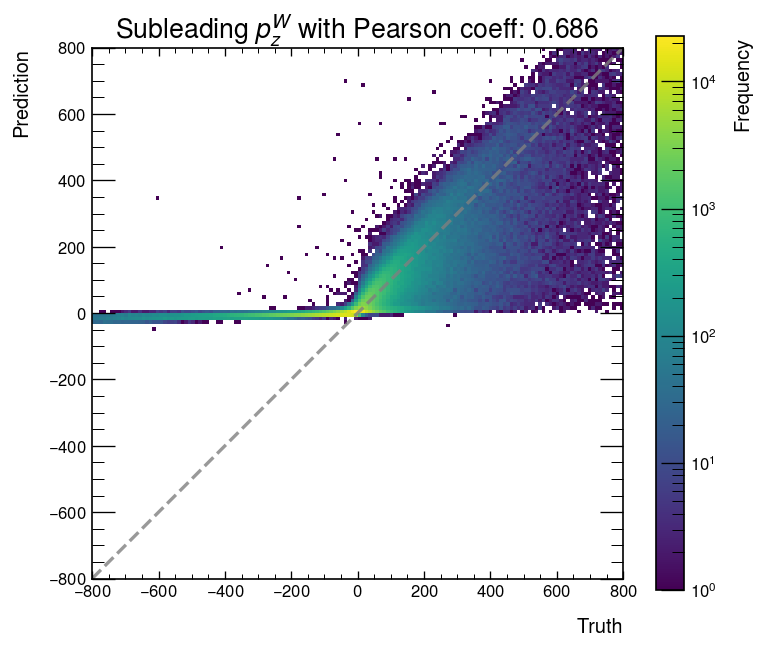

In [17]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-800, 800]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}^{W}$",
    title="Subleading $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"Subleading $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=set_range,
)

Truth mean: 140.341, std: 162.053, min: 7.208, max: 3217.117


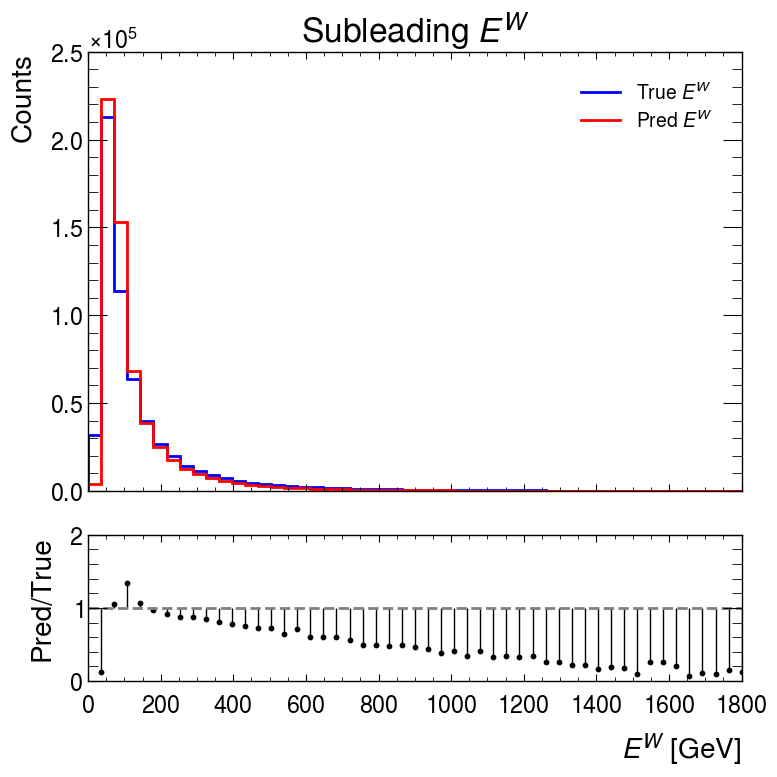

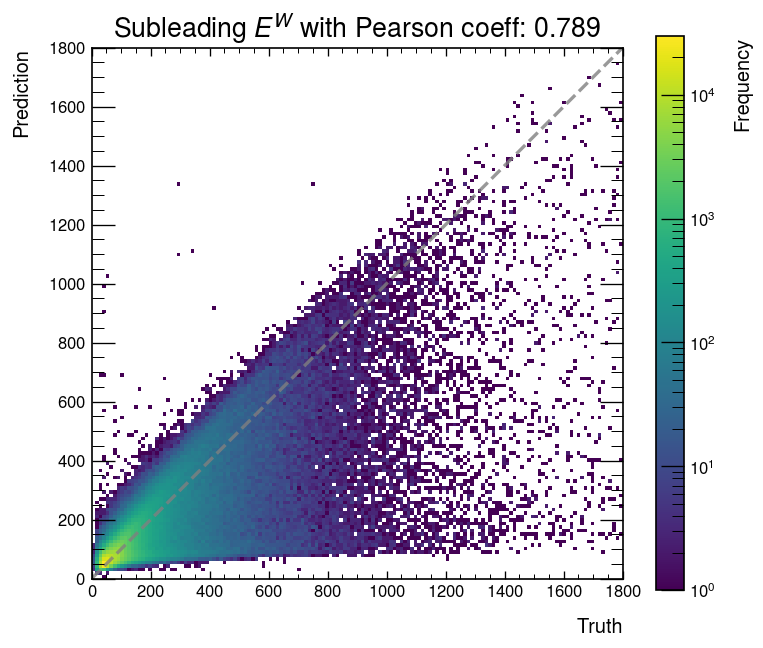

In [18]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 1800]

plot.hist(
    data=[sig_truth_inv[:,3], sig_pred_inv[:,3]],
    label=r"$E^{W}$",
    title="Subleading $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:,3],
    sig_pred_inv[:,3],
    r"Subleading $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=set_range,
)

In [19]:
w_mass = 80.377 # GeV
sig_truth_energy_full = np.sqrt(
    np.square(w_mass)
    + np.sum(np.square(w_lead[["px", "py", "pz"]][PRE_CUT].to_numpy() / GEV), axis=-1)
)
sig_truth_energy = np.sqrt(
    np.square(w_mass)
    + np.sum(np.square(sig_truth_inv), axis=-1)
)
sig_pred_energy = np.sqrt(
    np.square(w_mass)
    + np.sum(np.square(sig_pred_inv), axis=-1)
)

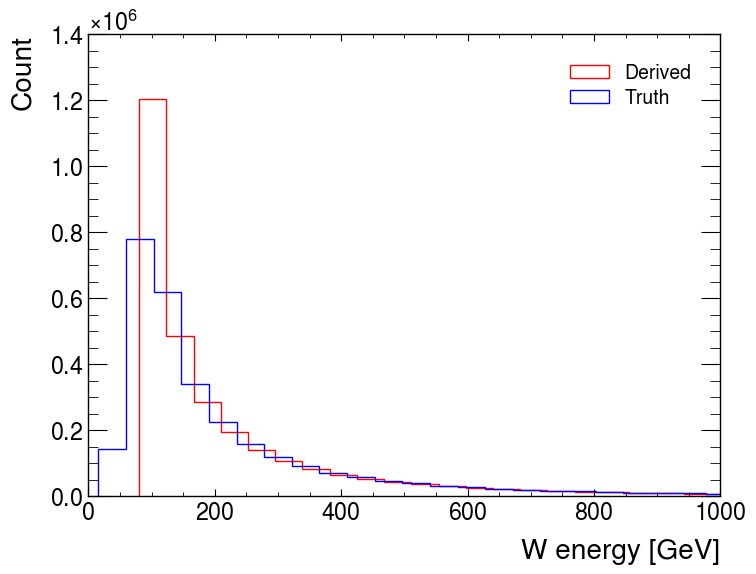

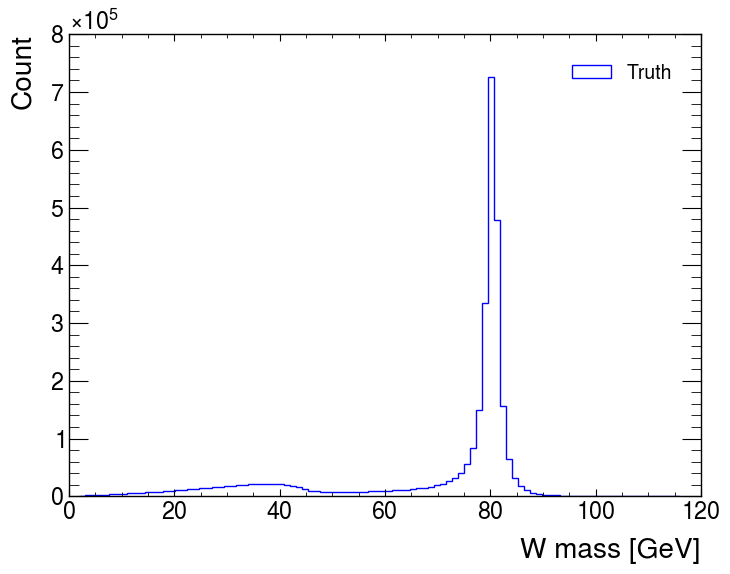

In [20]:
plt.hist(sig_truth_energy_full, bins=100, color="r", histtype="step", label="Derived")
plt.hist(w_lead[["E"]][PRE_CUT]/GEV, bins=100, color="b", histtype="step", label="Truth")
plt.legend()
plt.xlim([0, 1000])
plt.xlabel("W energy [GeV]")
plt.ylabel("Count")
plt.show()
plt.close()

plt.hist(w_lead[["m"]][PRE_CUT]/GEV, bins=100, color="b", histtype="step", label="Truth")
plt.legend()
plt.xlim([0, 120])
plt.xlabel("W mass [GeV]")
plt.ylabel("Count")
plt.show()
plt.close()

Truth mean: 217.890, std: 221.421, min: 80.946, max: 4549.655


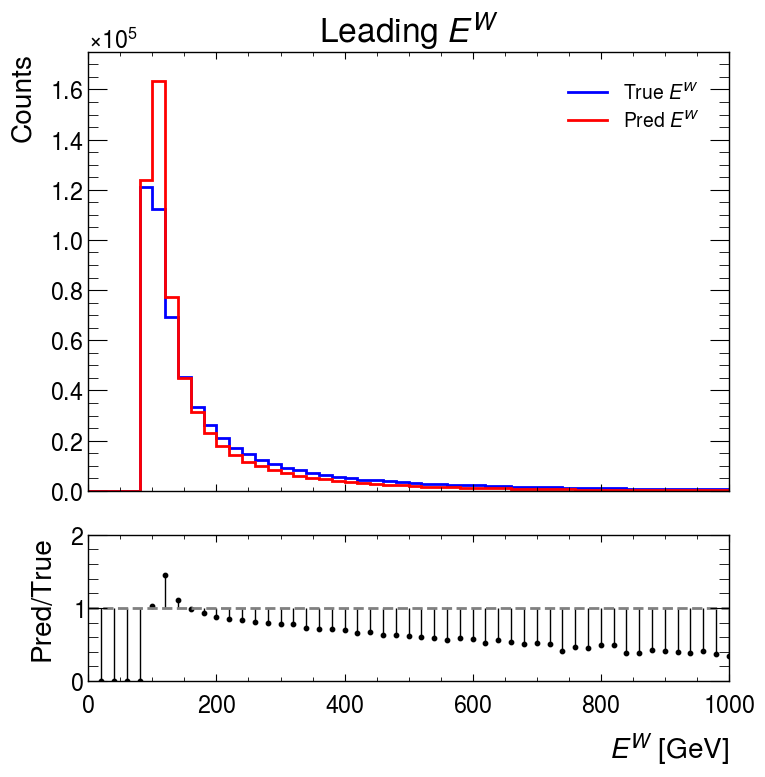

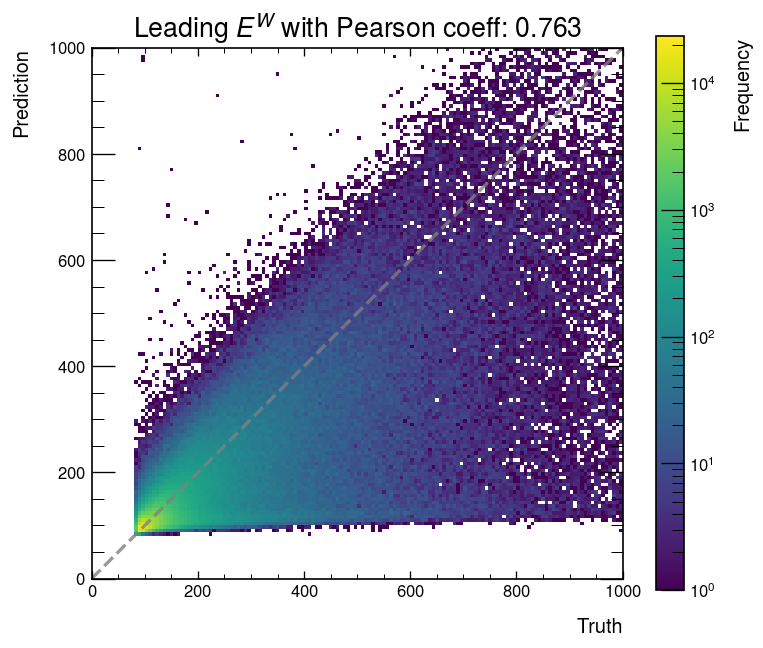

In [21]:
# TODO
# energy
print(
    f"Truth mean: {np.mean(sig_truth_energy):.3f}, std: {np.std(sig_truth_energy):.3f}, min: {np.min(sig_truth_energy):.3f}, max: {np.max(sig_truth_energy):.3f}"
)

set_range = [0, 1000]

plot.hist(
    data=[sig_truth_energy, sig_pred_energy],
    label=r"$E^{W}$",
    title="Leading $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_energy, sig_pred_energy)):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_energy,
    sig_pred_energy,
    r"Leading $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_energy, sig_pred_energy)[0]:.3f}",
    range=set_range,
)

In [22]:
mpl.rcParams.update(mpl.rcParamsDefault)

feature_names = [
    "lead_E",
    "lead_px",
    "lead_py",
    "lead_pz",
    "lead_pt",
    "lead_eta",
    "lead_phi",
    "sublead_E",
    "sublead_px",
    "sublead_py",
    "sublead_pz",
    "sublead_pt",
    "sublead_eta",
    "sublead_phi",
    "met_px",
    "met_py",
]
# lead
# Use DeepExplainer for SHAP values
explainer = shap.DeepExplainer(model, obs_kin[:1_024])
shap_values = explainer.shap_values(obs_kin[:1_024])
for i in range(shap_values.shape[-1]):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:, :, i],
        obs_kin[:1_024],
        feature_names=feature_names,
        plot_type="dot",
        show=False,
    )
    plt.title(f"SHAP Summary Plot for Lead Output: {feature_names[i+1]}")
    plt.show()

/opt/miniconda3/envs/work_env/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/miniconda3/envs/work_env/lib/python3.9/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: tensorflow - Max. diff: 0.01522064208984375 - Tolerance: 0.01